#Imported requied libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from IPython.display import Audio

#Load the dataset

In [ ]:
csv_file = "/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv"
data_dir = "/content/drive/MyDrive/UrbanSound8K/audio"
metadata = pd.read_csv(csv_file)

In [ ]:
if os.path.exists(csv_file):
    print("File exists✅!")
else:
    print("File not found❌.")

File exists✅!


In [ ]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


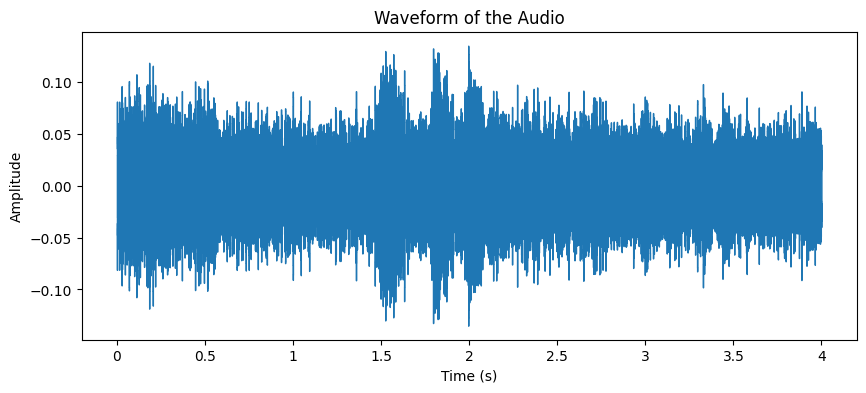

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

file_path = "/content/drive/MyDrive/UrbanSound8K/audio/fold2/102871-8-0-10.wav"

# Load audio file
y, sr = librosa.load(file_path, sr=None)

# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of the Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the audio
Audio(y, rate=sr)


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


#Load Metadata & Find Files

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from tqdm import tqdm  # ✅ Progress bar

# Load Metadata
metadata_path ="/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)

# ✅ Function to Find Audio Files
def find_file(file_name, base_dir="/content/drive/MyDrive/UrbanSound8K/audio"):
    """Search for the file in fold1 to fold10 and return the path."""
    for folder in range(1, 11):
        file_path = os.path.join(base_dir, f"fold{folder}", file_name)
        if os.path.exists(file_path):
            return file_path
    return None  # File not found


#Feature Extraction (Mel Spectogram)

In [ ]:
def extract_features(file_path, fixed_length=168):
    """Extract Mel Spectrogram with a consistent shape (168, 168)."""
    try:
        audio, sr = librosa.load(file_path, sr=22050, mono=True)
        n_fft = min(2048, len(audio))  # Ensure valid n_fft

        # **Extract Log-Mel Spectrogram**
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_fft=n_fft, n_mels=168, fmax=8000
        )
        mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # **Fix shape to (168, 168)**
        if mel_db.shape[1] > fixed_length:
            mel_db = mel_db[:, :fixed_length]  # Trim
        else:
            mel_db = np.pad(mel_db, ((0, 0), (0, fixed_length - mel_db.shape[1])), mode='constant')  # Pad

        return mel_db  # Return spectrogram only

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None  # Handle errors gracefully


<h1>Load and process data </h1>

In [ ]:
# Process dataset
X = []
y = []

for index, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = find_file(row['slice_file_name'], data_dir)
    if file_path:
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(row['classID'])

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # Shape: (8732, 168, 168)
y = np.array(y)

# **Expand dimensions correctly**
X = np.expand_dims(X, axis=-1)  # Shape: (8732, 168, 168, 1)

# ✅ Final Check
print("✅ Final Feature Shape:", X.shape)  # Expected: (8732, 168, 168, 1)
print("✅ Labels Shape:", y.shape)   # Expected: (8732,)


100%|██████████| 8732/8732 [44:15<00:00,  3.29it/s]


✅ Final Feature Shape: (8732, 168, 168, 1)
✅ Labels Shape: (8732,)


In [ ]:
print(f"Sample feature shape before conversion: {X[0].shape}")

Sample feature shape before conversion: (168, 168, 1)


#Preprocess for CNN

In [ ]:
# ✅ Split Data (Before Normalization)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Normalize Training & Testing Data (After Splitting)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# ✅ Check shapes again
print("✅ Training Shape:", X_train.shape)  # Must be (6985, 168, 168, 1)
print("✅ Testing Shape:", X_test.shape)    # Must be (1747, 168, 168, 1)

✅ Training Shape: (6985, 168, 168, 1)
✅ Testing Shape: (1747, 168, 168, 1)


In [ ]:
print(f"✅ Fixed y_train shape: {y_train.shape}")  # Expected: (6985,)
print(f"✅ Fixed y_test shape: {y_test.shape}")  # Expected: (1747,)

✅ Fixed y_train shape: (6985,)
✅ Fixed y_test shape: (1747,)


In [ ]:
# One-hot encode labels
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# Check final shape
print(f"✅ y_train shape after encoding: {y_train.shape}")  # Expected: (6985, 10)
print(f"✅ y_test shape after encoding: {y_test.shape}")  # Expected: (1747, 10)

✅ y_train shape after encoding: (6985, 10)
✅ y_test shape after encoding: (1747, 10)


#Plot Distribution

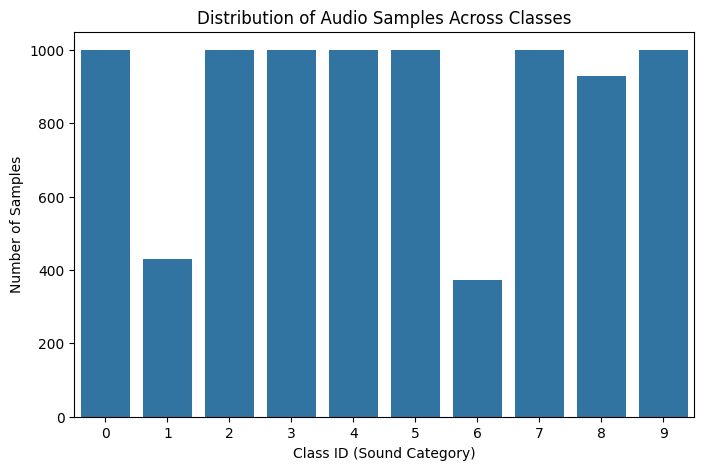

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Use y directly (if it contains class labels)
class_counts = y

# ✅ Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=class_counts)
plt.xlabel("Class ID (Sound Category)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Audio Samples Across Classes")
plt.show()


#Build the CNN model

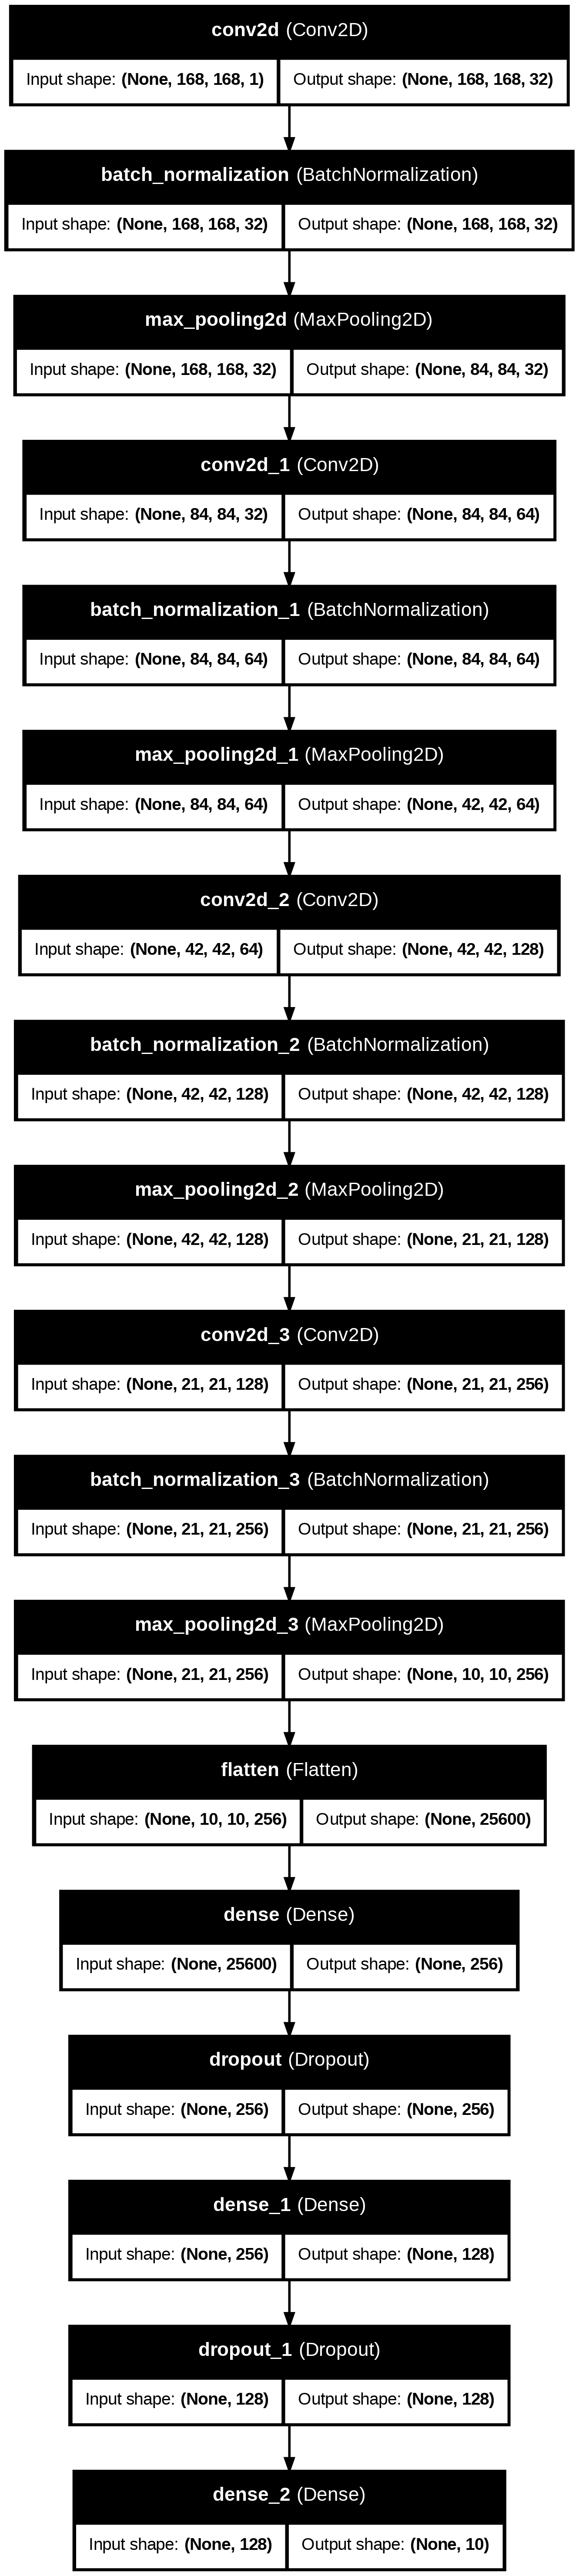

In [ ]:
from tensorflow.keras.utils import plot_model
# **8️⃣ Define CNN Model**
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2], 1)),

    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Conv Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# **9️⃣ Compile Model**
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Generate and save the model architecture diagram
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 168, 168, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 168, 168, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 84, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977,802 (26.62 MB)

 Trainable params: 6,976,842 (26.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:

# Predict
prediction = model.predict(X)
predicted_class = np.argmax(prediction)

273/273 ━━━━━━━━━━━━━━━━━━━━ 220s 803ms/step


In [ ]:
predicted_class

np.int64(51316)

#Train the model

In [23]:
# ✅ Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# ✅ Train Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 799s 4s/step - accuracy: 0.2692 - loss: 4.2701 - val_accuracy: 0.1122 - val_loss: 20.3061 - learning_rate: 0.0010
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 838s 4s/step - accuracy: 0.4337 - loss: 1.6912 - val_accuracy: 0.3824 - val_loss: 2.5204 - learning_rate: 0.0010
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 828s 4s/step - accuracy: 0.4924 - loss: 1.5150 - val_accuracy: 0.5615 - val_loss: 1.2560 - learning_rate: 0.0010
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 792s 4s/step - accuracy: 0.5543 - loss: 1.2950 - val_accuracy: 0.6342 - val_loss: 1.0308 - learning_rate: 0.0010
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 809s 4s/step - accuracy: 0.6402 - loss: 1.0601 - val_accuracy: 0.7212 - val_loss: 0.9095 - learning_rate: 0.0010
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 795s 4s/step - accuracy: 0.7246 - loss: 0.8579 - val_accuracy: 0.7745 - val_loss: 0.7293 - learning_rate: 0.0010
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 795s 4s/step - accuracy: 0.7603 - loss: 0

In [24]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss*100:.2f}%")

# Access training and validation accuracy from the history object
train_acc = history.history['accuracy'][-1]  # Last epoch training accuracy
val_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 746ms/step - accuracy: 0.9414 - loss: 0.3020
Test Accuracy: 94.50%
Test Loss: 23.53%
Train Accuracy: 98.71%
Validation Accuracy: 94.28%


#Plotting

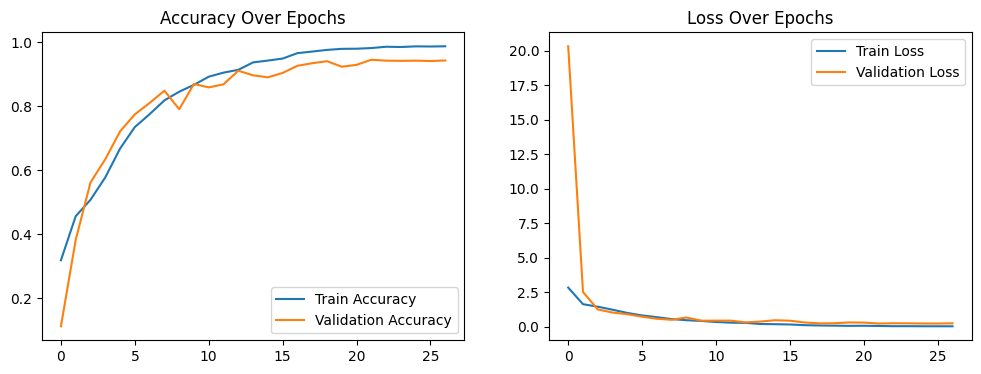

In [25]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

In [26]:
model.save("/content/drive/MyDrive/Urbansound8K_using_CNN.keras")

In [27]:
model.save("/content/drive/MyDrive/Urbansound8K_using_CNN.h5")

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [29]:
from sklearn.metrics import confusion_matrix

# Predict class probabilities
y_pred_probs = model.predict(X_test)  # Ensure X_test has the correct shape

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # ✅ Convert to predicted class labels
y_test_classes = np.argmax(y_test, axis=1)        # ✅ Convert y_test from one-hot to labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)


55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 862ms/step
Confusion Matrix:
[[188   1   2   0   0   6   0   1   1   1]
 [  0  82   0   0   2   0   0   2   0   0]
 [  0   0 187   5   1   0   0   0   1   6]
 [  1   0   6 186   0   3   0   0   2   2]
 [  1   0   1   1 189   0   0   5   2   1]
 [  1   0   4   0   0 191   0   2   1   1]
 [  0   0   0   0   0   0  75   0   0   0]
 [  1   0   0   1   6   0   0 192   0   0]
 [  0   0   1   1   0   1   0   0 183   0]
 [  4   1  10   0   2   1   0   1   3 178]]


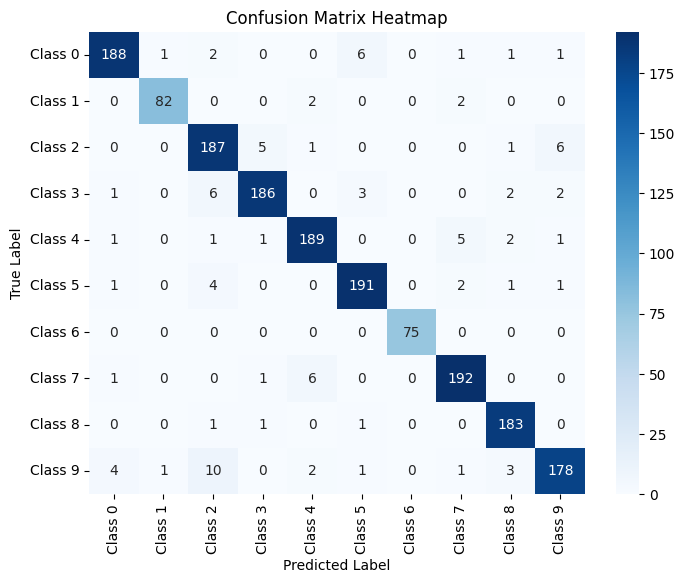

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names if available
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7", "Class 8", "Class 9"]  # Update with actual class names

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [33]:
from sklearn.metrics import classification_report
import numpy as np

# Convert one-hot encoded y_test to label format
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Convert predictions to label format
if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

# Print classification report
report = classification_report(y_test_labels, y_pred_labels)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       200
           1       0.98      0.95      0.96        86
           2       0.89      0.94      0.91       200
           3       0.96      0.93      0.94       200
           4       0.94      0.94      0.94       200
           5       0.95      0.95      0.95       200
           6       1.00      1.00      1.00        75
           7       0.95      0.96      0.95       200
           8       0.95      0.98      0.97       186
           9       0.94      0.89      0.92       200

    accuracy                           0.95      1747
   macro avg       0.95      0.95      0.95      1747
weighted avg       0.95      0.95      0.95      1747



55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 750ms/step


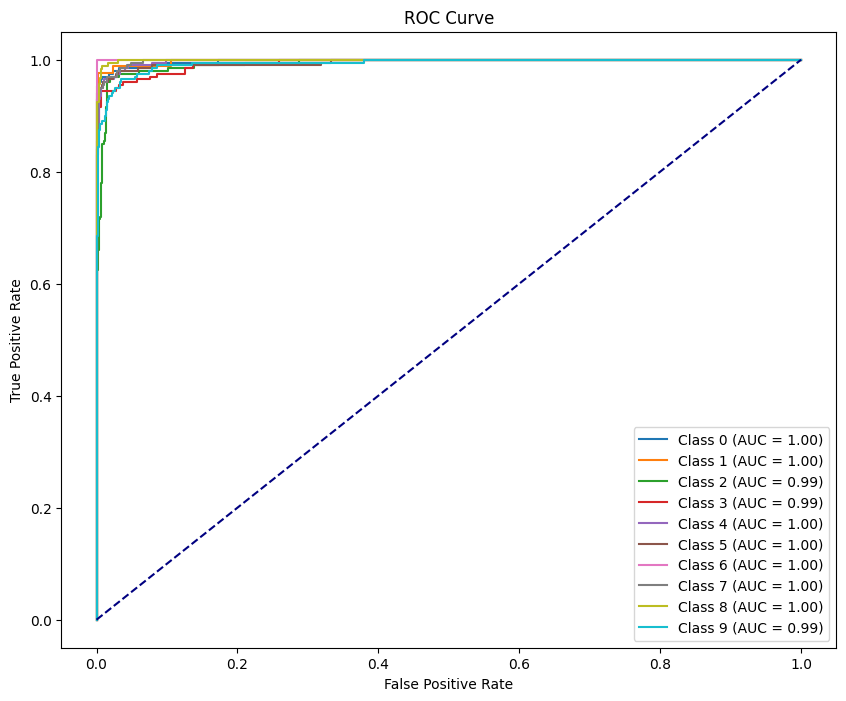

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Binarize the labels for multi-class
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Get the predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 783ms/step


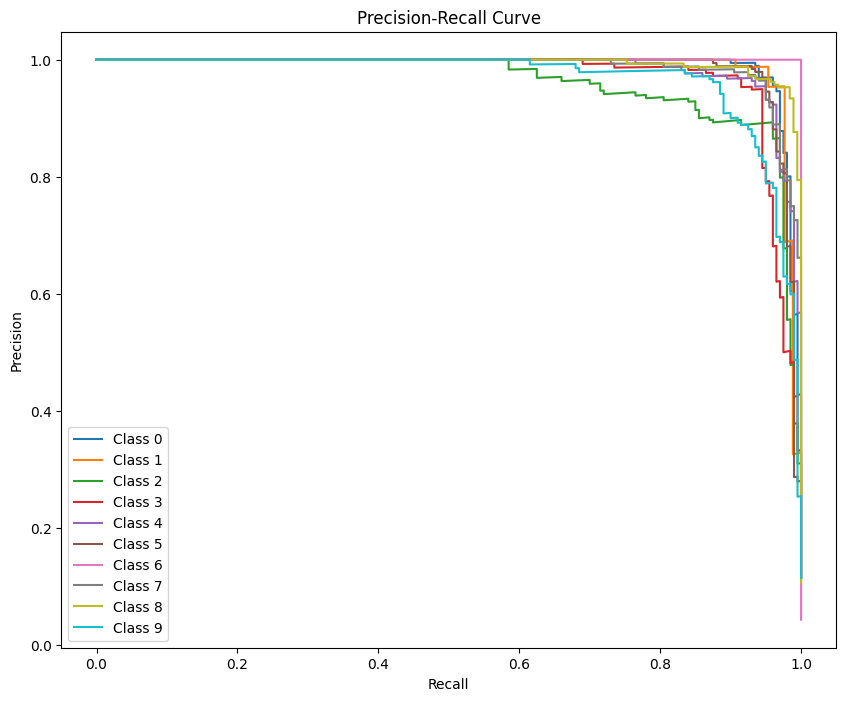

In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities (binary or multi-class)
y_pred_prob = model.predict(X_test)

# Precision-Recall curve for each class
plt.figure(figsize=(10, 8))

for i in range(y_test_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()


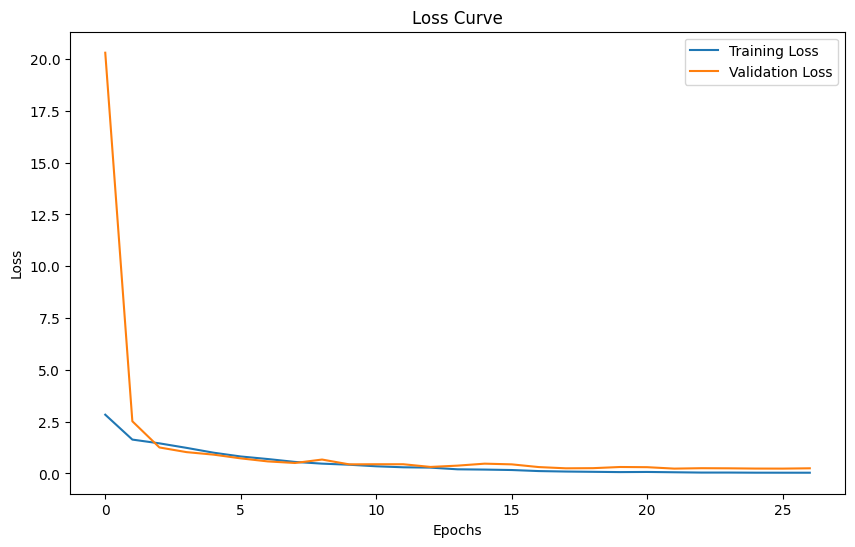

In [36]:
# Assuming you have history from training your Keras model
# Example: history = model.fit(...)

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

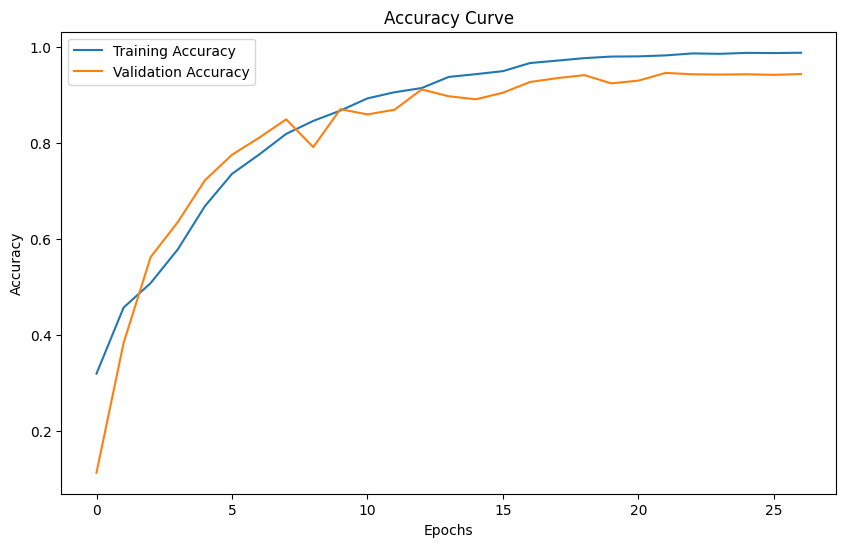

In [37]:
# Assuming you have history from training your Keras model
# Example: history = model.fit(...)

# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Load the saved model


✅ Predicted Class: street_music (ID: 9)


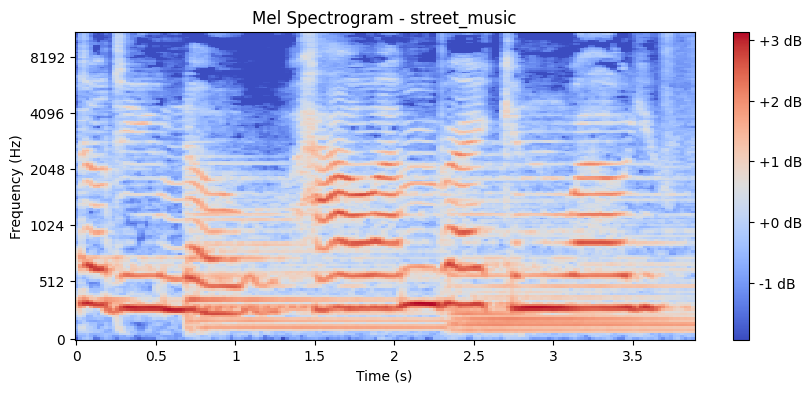

In [38]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

# ✅ Load Trained Model
model_path = "/content/drive/MyDrive/Urbansound8K_using_CNN.keras"
model = load_model(model_path)

# ✅ Load metadata & create class mapping
metadata_path = "/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)
class_mapping = dict(zip(metadata['classID'], metadata['class']))  # Map Class ID -> Class Name

# ✅ Feature Extraction Function
def extract_features(file_path, fixed_length=168):
    """Extracts Mel Spectrogram features with a fixed shape (168, 168)."""
    try:
        audio, sr = librosa.load(file_path, sr=22050, mono=True)  # Load audio
        n_fft = min(2048, len(audio))  # Ensure n_fft is valid

        # Extract Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, n_mels=168, fmax=8000)
        mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Ensure fixed shape (168, 168)
        if mel_db.shape[1] > fixed_length:
            mel_db = mel_db[:, :fixed_length]
        else:
            mel_db = np.pad(mel_db, ((0, 0), (0, fixed_length - mel_db.shape[1])), mode='constant')

        return mel_db, sr, audio

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None, None, None

# ✅ Prediction Function


# ✅ Use @tf.function to prevent excessive retracing
@tf.function(reduce_retracing=True)
def make_prediction(model, input_tensor):
    """Runs model prediction on a single preprocessed input tensor."""
    return model(input_tensor, training=False)

def predict_audio(file_path):
    """Loads an audio file, extracts features, and predicts its class."""
    features, sr, audio = extract_features(file_path)

    if features is None:
        print("❌ Error extracting features.")
        return

    # ✅ Normalize & Reshape
    features = (features - np.mean(features)) / np.std(features)  # Normalize
    features = np.expand_dims(features, axis=-1)  # Add channel dim -> (168, 168, 1)
    features = np.expand_dims(features, axis=0)   # Add batch dim -> (1, 168, 168, 1)

    # ✅ Convert to TensorFlow tensor (avoids retracing issues)
    input_tensor = tf.convert_to_tensor(features, dtype=tf.float32)

    # ✅ Make Prediction using the pre-compiled function
    prediction = make_prediction(model, input_tensor)
    predicted_class = np.argmax(prediction.numpy())  # Convert back to NumPy for mapping

    # ✅ Get class label
    predicted_label = class_mapping.get(predicted_class, "Unknown")

    # 🎯 Display Results
    print(f"✅ Predicted Class: {predicted_label} (ID: {predicted_class})")


    # 🔊 Play Original Audio
    from IPython.display import Audio
    display(Audio(audio, rate=sr))

    # 🎵 Plot Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(features[0, :, :, 0], sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram - {predicted_label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# 🔥 **Test on a New Audio File**
test_file = "/content/drive/MyDrive/UrbanSound8K/Sample_Sound/little _do_you_know.wav"
predict_audio(test_file)
